# Quick Start Tutorial

GluonTS contains:

* A number of pre-built models
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

/home/sunkai/miniconda3/envs/ts_test/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [4]:
dataset = get_dataset("m4_hourly")

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

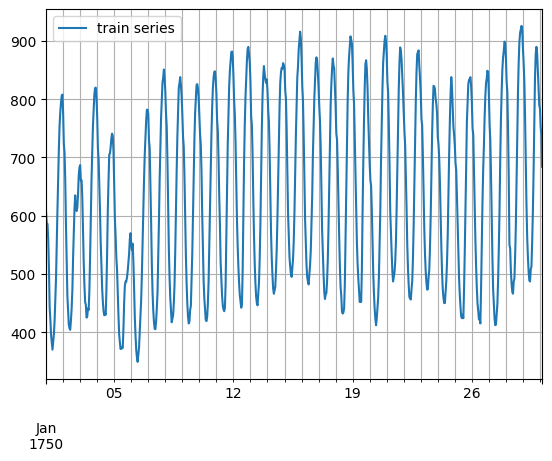

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

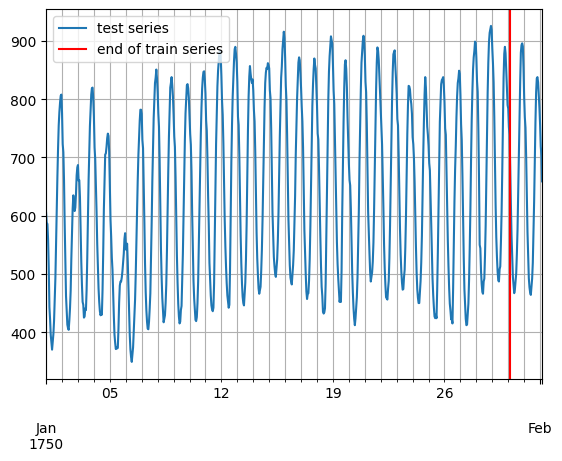

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Period` (possibly different for each time series):

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [9]:
from gluonts.dataset.common import ListDataset

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GluonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of an `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [12]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 86.15it/s, epoch=5/5, avg_epoch_loss=4.67]


## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all this information by simply invoking the corresponding attribute of the forecast object.

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [645.177   600.75745 431.2948  546.8709  459.5172  450.8486  456.90894
 447.47263 504.22626 577.16    620.122   671.9691  668.3977  785.8437
 839.6054  863.5349  856.6344  869.83936 803.9943  844.80914 766.89136
 715.8795  741.4953  713.2297  588.80524 558.6117  459.2719  483.56833
 451.7223  499.59418 480.89008 454.90152 527.4246  566.4461  600.5953
 672.55884 767.4294  745.0691  930.77686 876.3608  937.1301  928.7124
 801.06635 858.46906 799.60345 747.8607  723.4973  731.8311 ]
0.5-quantile (median) of the future window:
 [655.5933  596.06384 454.02515 553.2788  454.82257 455.5657  471.53397
 449.298   507.7119  563.1287  616.97986 656.7812  678.2066  803.08405
 844.41064 867.8843  861.6912  875.0992  801.59644 840.1489  770.192
 702.601   728.7749  696.2222  587.77203 562.59045 467.5551  484.06073
 451.4458  486.7626  458.9541  453.17957 526.8751  560.8072  596.0887
 665.60675 747.3083  748.84204 935.51166 888.97595 936.2237  942.54675
 805.27594 835.9042

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

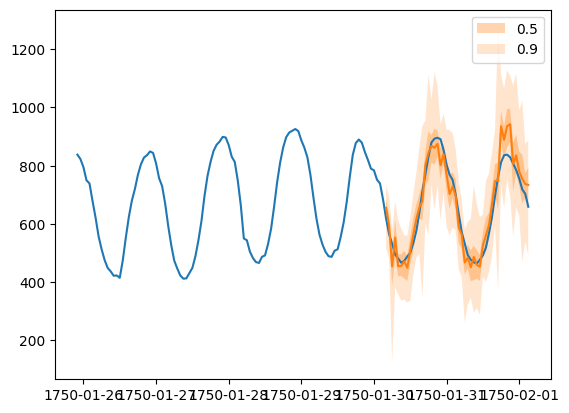

In [24]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [25]:
from gluonts.evaluation import Evaluator

In [26]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 414it [00:00, 8984.86it/s]


The aggregate metrics, `agg_metrics`, aggregate both across time-steps and across time series.

In [27]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 6988949.4742347365,
    "abs_error": 8316834.419900894,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.6513589172188023,
    "MAPE": 0.24457405532759743,
    "sMAPE": 0.19704851030631532,
    "MSIS": 61.419285361689795,
    "QuantileLoss[0.1]": 5535442.672861289,
    "Coverage[0.1]": 0.09420289855072464,
    "QuantileLoss[0.5]": 8316834.358647823,
    "Coverage[0.5]": 0.3936191626409018,
    "QuantileLoss[0.9]": 6022365.254002379,
    "Coverage[0.9]": 0.859098228663446,
    "RMSE": 2643.6621331468846,
    "NRMSE": 0.360918274646628,
    "ND": 0.05713725852365897,
    "wQuantileLoss[0.1]": 0.03802889453772944,
    "wQuantileLoss[0.5]": 0.05713725810284591,
    "wQuantileLoss[0.9]": 0.04137408815287385,
    "mean_absolute_QuantileLoss": 6624880.761837165,
    "mean_wQuantileLoss": 0.0455134135978164,
    "MAE_Coverage": 0.3863660762211487,
    "OWA": NaN
}


Individual metrics are aggregated only across time-steps.

In [28]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,2304.004883,1772.675049,31644.0,659.250000,42.371302,0.871598,0.055979,0.055502,0.056019,13.191181,1083.401611,0.0000,1772.675110,0.500000,1230.321118,1.000000
1,1,1750-01-30 04:00,110523.177083,13817.460938,124149.0,2586.437500,165.107988,1.743488,0.115160,0.107036,0.111297,13.199884,3516.570020,0.1250,13817.461304,0.937500,7558.454492,1.000000
2,2,1750-01-30 04:00,42850.393229,7611.635742,65030.0,1354.791667,78.889053,2.010111,0.105028,0.113538,0.117048,13.475501,3701.313525,0.0000,7611.635315,0.041667,3189.089441,0.687500
3,3,1750-01-30 04:00,208732.583333,18179.960938,235783.0,4912.145833,258.982249,1.462452,0.073056,0.075311,0.077105,14.332286,10335.453711,0.0000,18179.959961,0.250000,6387.535303,0.979167
4,4,1750-01-30 04:00,77960.656250,9232.525391,131088.0,2731.000000,200.494083,0.959351,0.070079,0.067096,0.070430,12.281370,5675.114868,0.0625,9232.525391,0.562500,6232.817480,1.000000


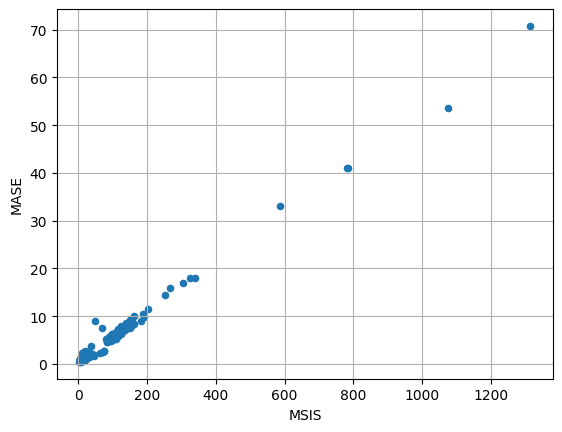

In [29]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()